In [1]:
print(2)

2


In [2]:
!pip install -q evaluate torchinfo bitsandbytes peft

In [3]:
import numpy as np
import pandas as pd
from datasets import Dataset
import evaluate
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer
from torchinfo import summary
import torch
from transformers import BertTokenizer, BertForSequenceClassification, BitsAndBytesConfig
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [4]:
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Datasets, Tokenizer, and Model

In [6]:
train_df = pd.read_csv('/content/drive/MyDrive/266/MLMA_Toxicity_Detection_Deep_Learning/Data/combined_train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/266/MLMA_Toxicity_Detection_Deep_Learning/Data/combined_val.csv')
test_df = pd.read_csv('/content/drive/MyDrive/266/MLMA_Toxicity_Detection_Deep_Learning/Data/combined_test.csv')

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

## Multi-Label Prediction

In [7]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

example = train_dataset[0]
example

{'text_cleaned': 'يلعن شرفك يا حكم!!!',
 'language': 'arabic',
 'directness_label': 2,
 'target_label': 2,
 'group_label': 12,
 'hatespeech': 0,
 'hatespeech.1': 0,
 'directness_label.1': 2,
 'target_label.1': 2,
 'group_label.1': 12,
 'sentiment_anger': 0,
 'sentiment_confusion': 0,
 'sentiment_disgust': 0,
 'sentiment_fear': 0,
 'sentiment_indifference': 0,
 'sentiment_normal': 1,
 'sentiment_sadness': 0,
 'sentiment_shock': 0,
 'language_encoded': 2}

In [8]:
from datasets import DatasetDict

dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text_cleaned', 'language', 'directness_label', 'target_label', 'group_label', 'hatespeech', 'hatespeech.1', 'directness_label.1', 'target_label.1', 'group_label.1', 'sentiment_anger', 'sentiment_confusion', 'sentiment_disgust', 'sentiment_fear', 'sentiment_indifference', 'sentiment_normal', 'sentiment_sadness', 'sentiment_shock', 'language_encoded'],
        num_rows: 30702
    })
    validation: Dataset({
        features: ['text_cleaned', 'language', 'directness_label', 'target_label', 'group_label', 'hatespeech', 'hatespeech.1', 'directness_label.1', 'target_label.1', 'group_label.1', 'sentiment_anger', 'sentiment_confusion', 'sentiment_disgust', 'sentiment_fear', 'sentiment_indifference', 'sentiment_normal', 'sentiment_sadness', 'sentiment_shock', 'language_encoded'],
        num_rows: 3901
    })
    test: Dataset({
        features: ['text_cleaned', 'language', 'directness_label', 'target_label', 'group_label', 'hatespeech', 

In [9]:
example = dataset['train'][13000]
example

{'text_cleaned': "c'est un gros mongol quand même",
 'language': 'french',
 'directness_label': 0,
 'target_label': 3,
 'group_label': 8,
 'hatespeech': 1,
 'hatespeech.1': 1,
 'directness_label.1': 0,
 'target_label.1': 3,
 'group_label.1': 8,
 'sentiment_anger': 0,
 'sentiment_confusion': 0,
 'sentiment_disgust': 0,
 'sentiment_fear': 0,
 'sentiment_indifference': 0,
 'sentiment_normal': 0,
 'sentiment_sadness': 0,
 'sentiment_shock': 1,
 'language_encoded': 1}

In [10]:
# Original binary labels
binary_label_columns = [
    'hatespeech',
    'sentiment_indifference',
    'sentiment_disgust',
    'sentiment_sadness',
    'sentiment_anger',
    'sentiment_shock',
    'sentiment_normal',
    'sentiment_confusion',
    'sentiment_fear'
]

# Get unique values for multiclass labels to determine the range for one-hot encoding
directness_values = sorted(train_df['directness_label'].unique().tolist())
target_values = sorted(train_df['target_label'].unique().tolist())
group_values = sorted(train_df['group_label'].unique().tolist())

# Create names for one-hot encoded binary labels
directness_binary_labels = [f'directness_label_{val}' for val in directness_values]
target_binary_labels = [f'target_label_{val}' for val in target_values]
group_binary_labels = [f'group_label_{val}' for val in group_values]

# Combine all binary label names
all_binary_labels = binary_label_columns + directness_binary_labels + target_binary_labels + group_binary_labels

# Update id2label and label2id
id2label = {idx:label for idx, label in enumerate(all_binary_labels)}
label2id = {label:idx for idx, label in enumerate(all_binary_labels)}

# The total number of binary labels
num_binary_labels = len(all_binary_labels)

print(f"Total number of binary labels: {num_binary_labels}")
print(f"All binary labels: {all_binary_labels}")

Total number of binary labels: 36
All binary labels: ['hatespeech', 'sentiment_indifference', 'sentiment_disgust', 'sentiment_sadness', 'sentiment_anger', 'sentiment_shock', 'sentiment_normal', 'sentiment_confusion', 'sentiment_fear', 'directness_label_0', 'directness_label_1', 'directness_label_2', 'target_label_0', 'target_label_1', 'target_label_2', 'target_label_3', 'target_label_4', 'target_label_5', 'target_label_6', 'group_label_0', 'group_label_1', 'group_label_2', 'group_label_3', 'group_label_4', 'group_label_5', 'group_label_6', 'group_label_7', 'group_label_8', 'group_label_9', 'group_label_10', 'group_label_11', 'group_label_12', 'group_label_13', 'group_label_14', 'group_label_15', 'group_label_16']


In [11]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained('google/rembert')
model = AutoModelForSequenceClassification.from_pretrained('google/rembert',
                                                           problem_type="multi_label_classification",
                                                           num_labels=len(all_binary_labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

tokenizer_config.json:   0%|          | 0.00/263 [00:00<?, ?B/s]

sentencepiece.model:   0%|          | 0.00/4.70M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/686 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.30G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.30G [00:00<?, ?B/s]

Some weights of RemBertForSequenceClassification were not initialized from the model checkpoint at google/rembert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
import torch
import numpy as np

# Get unique values for multiclass labels to determine the range for one-hot encoding
directness_values = sorted(train_df['directness_label'].unique().tolist())
target_values = sorted(train_df['target_label'].unique().tolist())
group_values = sorted(train_df['group_label'].unique().tolist())

def preprocess_multioutput_data(examples):
  # take a batch of texts
  text = [str(x) for x in examples["text_cleaned"]]
  # encode them, returning PyTorch tensors directly
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=100, return_tensors="pt")

  # Create a list of binary label tensors, starting with the 'hatespeech' label
  binary_labels_list = [
      torch.tensor(examples["hatespeech"])
  ]

  # Add other binary sentiment labels
  sentiment_labels = [
      "sentiment_anger",
      "sentiment_confusion",
      "sentiment_disgust",
      "sentiment_fear",
      "sentiment_indifference",
      "sentiment_normal",
      "sentiment_sadness",
      "sentiment_shock"
  ]
  for label in sentiment_labels:
      binary_labels_list.append(torch.tensor(examples[label]))


  # Perform one-hot encoding for multiclass labels and add to the list
  for i, val in enumerate(directness_values):
      binary_labels_list.append(torch.tensor([1.0 if label == val else 0.0 for label in examples["directness_label"]]))

  for i, val in enumerate(target_values):
      binary_labels_list.append(torch.tensor([1.0 if label == val else 0.0 for label in examples["target_label"]]))

  for i, val in enumerate(group_values):
      binary_labels_list.append(torch.tensor([1.0 if label == val else 0.0 for label in examples["group_label"]]))


  # Stack all binary label tensors along dimension 1
  # Ensure all tensors in the list have the same length before stacking
  # (This should be guaranteed by the batching process, but it's good practice)
  labels_tensor = torch.stack(binary_labels_list, dim=1).float()


  # Add the stacked labels tensor to the encoding dictionary
  encoding['labels'] = labels_tensor

  return encoding

# Apply the preprocessing function with batching
encoded_dataset = dataset.map(preprocess_multioutput_data, batched=True, remove_columns=dataset['train'].column_names)


Map:   0%|          | 0/30702 [00:00<?, ? examples/s]

Map:   0%|          | 0/3901 [00:00<?, ? examples/s]

Map:   0%|          | 0/3901 [00:00<?, ? examples/s]

In [13]:
from transformers import RemBertForSequenceClassification
import torch.nn as nn
import torch
from transformers.modeling_outputs import SequenceClassifierOutput

import torch.nn as nn
# from transformers import SequenceClassifierOutput

class HierarchicalRemBert(RemBertForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)

        hidden_size = config.hidden_size  # RemBERT uses 'hidden_size'

        # Hatespeech head: binary classification
        self.hatespeech_classifier = nn.Linear(hidden_size, 1)

        # Other labels head
        num_remaining_labels = config.num_labels - 1
        self.other_labels_classifier = nn.Linear(hidden_size, num_remaining_labels)

        # Optional dropout (used in forward)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,  # shape: (batch_size, num_total_labels)
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # Get the output from the base RemBERT model
        rembert_output = self.rembert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        hidden_state = rembert_output[0]  # (batch_size, seq_len, hidden_size)
        cls_output = hidden_state[:, 0]   # [CLS] token representation

        pooled_output = self.dropout(cls_output)

        # Two separate outputs
        hatespeech_logits = self.hatespeech_classifier(pooled_output)         # (batch_size, 1)
        other_logits = self.other_labels_classifier(pooled_output)            # (batch_size, num_remaining_labels)

        # Concatenate logits for full label set
        logits = torch.cat([hatespeech_logits, other_logits], dim=1)          # (batch_size, num_labels)

        loss = None
        if labels is not None:
            loss_fct = nn.BCEWithLogitsLoss()
            loss = loss_fct(logits, labels.float())

        if not return_dict:
            output = (logits,) + rembert_output[1:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=rembert_output.hidden_states,
            attentions=rembert_output.attentions,
        )


## Instantiate and train the custom model


In [14]:
# Unfreeze classifier, pooler, and layer 3, 4, and 5

for name, param in model.named_parameters():
    if name.split(".")[0] == "rembert" and "encoder.layer.31" in name:
        param.requires_grad = True
    # elif name.split(".")[0] == "rembert" and "encoder.layer.30" in name:
    #     param.requires_grad = True
    # elif name.split(".")[0] == "rembert" and "encoder.layer.29" in name:
    #     param.requires_grad = True
    elif name in ["pre_classifier.weight", "pre_classifier.bias", "classifier.weight", "classifier.bias"]:
        param.requires_grad = True
    else:
        param.requires_grad = False

summary(model)

Layer (type:depth-idx)                                       Param #
RemBertForSequenceClassification                             --
├─RemBertModel: 1-1                                          --
│    └─RemBertEmbeddings: 2-1                                --
│    │    └─Embedding: 3-1                                   (64,076,800)
│    │    └─Embedding: 3-2                                   (131,072)
│    │    └─Embedding: 3-3                                   (512)
│    │    └─LayerNorm: 3-4                                   (512)
│    │    └─Dropout: 3-5                                     --
│    └─RemBertEncoder: 2-2                                   --
│    │    └─Linear: 3-6                                      (296,064)
│    │    └─ModuleList: 3-7                                  510,087,168
│    └─RemBertPooler: 2-3                                    --
│    │    └─Linear: 3-8                                      (1,328,256)
│    │    └─Tanh: 3-9                              

In [15]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
from transformers import EvalPrediction
import torch
import numpy as np

def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels.astype(int) # Ensure labels are integers
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro', zero_division=0)
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true=y_true, y_pred=y_pred, average='micro', zero_division=0)
    recall = recall_score(y_true=y_true, y_pred=y_pred, average='micro', zero_division=0)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy,
               'precision': precision,
               'recall': recall}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions,
            tuple) else p.predictions

    # Ensure labels are a 2D numpy array of integers
    labels_np = np.array(p.label_ids)
    if labels_np.ndim == 1:
        # This might happen if the batch size is 1, reshape to (1, num_labels)
        labels_np = labels_np.reshape(1, -1)
    elif labels_np.ndim > 2:
        # Handle cases where labels might have extra dimensions unexpectedly
        # This might require more specific reshaping based on the actual structure
        # For now, let's assume the expected shape is (batch_size, num_labels)
        # and try to flatten and reshape if necessary.
        # A safer approach might be to raise an error or log a warning here.
        print(f"Warning: Unexpected label dimension: {labels_np.ndim}")
        # Attempt to flatten and reshape - adjust if your data structure is different
        labels_np = labels_np.reshape(labels_np.shape[0], -1)


    result = multi_label_metrics(
        predictions=preds,
        labels=labels_np)
    return result


In [16]:
fp16=True

In [17]:
import torch
torch.cuda.empty_cache()

In [18]:

from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback

batch_size = 8 # 128

per_device_train_batch_size = 8
gradient_accumulation_steps = 16

metric_name = "eval_f1"

# args = TrainingArguments(
#     f"rembert-base_hierarchical", # Changed output directory name
#     eval_strategy = "epoch",
#     save_strategy = "epoch",
#     learning_rate=2e-5,
#     per_device_train_batch_size=batch_size,
#     per_device_eval_batch_size=batch_size,
#     num_train_epochs=3,
#     weight_decay=0.02,
#     load_best_model_at_end=True,
#     metric_for_best_model=metric_name,
#     greater_is_better=True,
#     report_to='none'
# )

args = TrainingArguments(
    output_dir="rembert-base_hierarchical",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=16,  # simulate batch_size=128
    num_train_epochs=3,
    weight_decay=0.02,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True,
    report_to='none',
    ddp_find_unused_parameters=False,
)

# Add EarlyStoppingCallback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,
    early_stopping_threshold=0.0
)

# Instantiate the HierarchicalRemBert model
# The config object is automatically loaded by from_pretrained and contains num_labels from the previous instantiation
model = HierarchicalRemBert.from_pretrained(
    "google/rembert",
    problem_type="multi_label_classification",
    num_labels=len(all_binary_labels), # Use the calculated total number of binary labels
    id2label=id2label,
    label2id=label2id
)

# Instantiate the Trainer
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback] # Add the early stopping callback
)

# Start training
trainer.train()

Some weights of HierarchicalRemBert were not initialized from the model checkpoint at google/rembert and are newly initialized: ['classifier.bias', 'classifier.weight', 'hatespeech_classifier.bias', 'hatespeech_classifier.weight', 'other_labels_classifier.bias', 'other_labels_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3501260591.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RemBertSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy,Precision,Recall
1,No log,0.148702,0.740716,0.816204,0.478083,0.860781,0.650045
2,No log,0.139556,0.758299,0.835185,0.482953,0.837226,0.692971
3,0.164300,0.137725,0.765155,0.841222,0.484748,0.835465,0.705760


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RemBertSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RemBertSelfAttention.forward`.
  return forward_call(*args, **kwargs)


TrainOutput(global_step=720, training_loss=0.15310321384006076, metrics={'train_runtime': 10856.2282, 'train_samples_per_second': 8.484, 'train_steps_per_second': 0.066, 'total_flos': 2.82836350462176e+16, 'train_loss': 0.15310321384006076, 'epoch': 3.0})

In [19]:
trainer.save_model("rembert-base_hierarchical_best")
tokenizer.save_pretrained("rembert-base_hierarchical_best")

('rembert-base_hierarchical_best/tokenizer_config.json',
 'rembert-base_hierarchical_best/special_tokens_map.json',
 'rembert-base_hierarchical_best/sentencepiece.model',
 'rembert-base_hierarchical_best/added_tokens.json',
 'rembert-base_hierarchical_best/tokenizer.json')

## Evaluate the Hierarchical Model

Evaluate the trained hierarchical model on the validation dataset using `trainer.evaluate()`. This will use the `compute_metrics` function defined previously.

In [20]:
trainer.evaluate()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RemBertSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'eval_loss': 0.1377248466014862,
 'eval_f1': 0.7651547721410146,
 'eval_roc_auc': 0.841222064188308,
 'eval_accuracy': 0.4847475006408613,
 'eval_precision': 0.8354653209717169,
 'eval_recall': 0.7057598889659958,
 'eval_runtime': 147.2709,
 'eval_samples_per_second': 26.489,
 'eval_steps_per_second': 3.314,
 'epoch': 3.0}

## Make Predictions and Visualize Results

Make predictions on the validation dataset, apply the hierarchical logic, and visualize confusion matrices separated by task and language.

In [21]:
import json

json_string = """
{
    "directness": {
        "0": "direct",
        "1": "indirect",
        "2": "normal"
    },
    "target": {
        "0": "disability",
        "1": "gender",
        "2": "normal",
        "3": "origin",
        "4": "other",
        "5": "religion",
        "6": "sexual_orientation"
    },
    "group": {
        "0": "african_descent",
        "1": "arabs",
        "2": "asians",
        "3": "christian",
        "4": "gay",
        "5": "hispanics",
        "6": "immigrants",
        "7": "indian/hindu",
        "8": "individual",
        "9": "jews",
        "10": "left_wing_people",
        "11": "muslims",
        "12": "normal",
        "13": "other",
        "14": "refugees",
        "15": "special_needs",
        "16": "women"
    }
}
"""

label_maps = json.loads(json_string)

directness_map = label_maps['directness']
target_map = label_maps['target']
group_map = label_maps['group']

print("Directness Map:")
print(directness_map)
print("\nTarget Map:")
print(target_map)
print("\nGroup Map:")
print(group_map)

Directness Map:
{'0': 'direct', '1': 'indirect', '2': 'normal'}

Target Map:
{'0': 'disability', '1': 'gender', '2': 'normal', '3': 'origin', '4': 'other', '5': 'religion', '6': 'sexual_orientation'}

Group Map:
{'0': 'african_descent', '1': 'arabs', '2': 'asians', '3': 'christian', '4': 'gay', '5': 'hispanics', '6': 'immigrants', '7': 'indian/hindu', '8': 'individual', '9': 'jews', '10': 'left_wing_people', '11': 'muslims', '12': 'normal', '13': 'other', '14': 'refugees', '15': 'special_needs', '16': 'women'}


### Full Confusion Matrices

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RemBertSelfAttention.forward`.
  return forward_call(*args, **kwargs)



--- Analyzing arabic ---
Skipping target_label_0 in arabic: Only one true class present in true labels.
Skipping target_label_6 in arabic: Only one true class present in true labels.
Skipping group_label_2 in arabic: Only one true class present in true labels.
Skipping group_label_5 in arabic: Only one true class present in true labels.
Skipping group_label_10 in arabic: Only one true class present in true labels.
Skipping group_label_15 in arabic: Only one true class present in true labels.


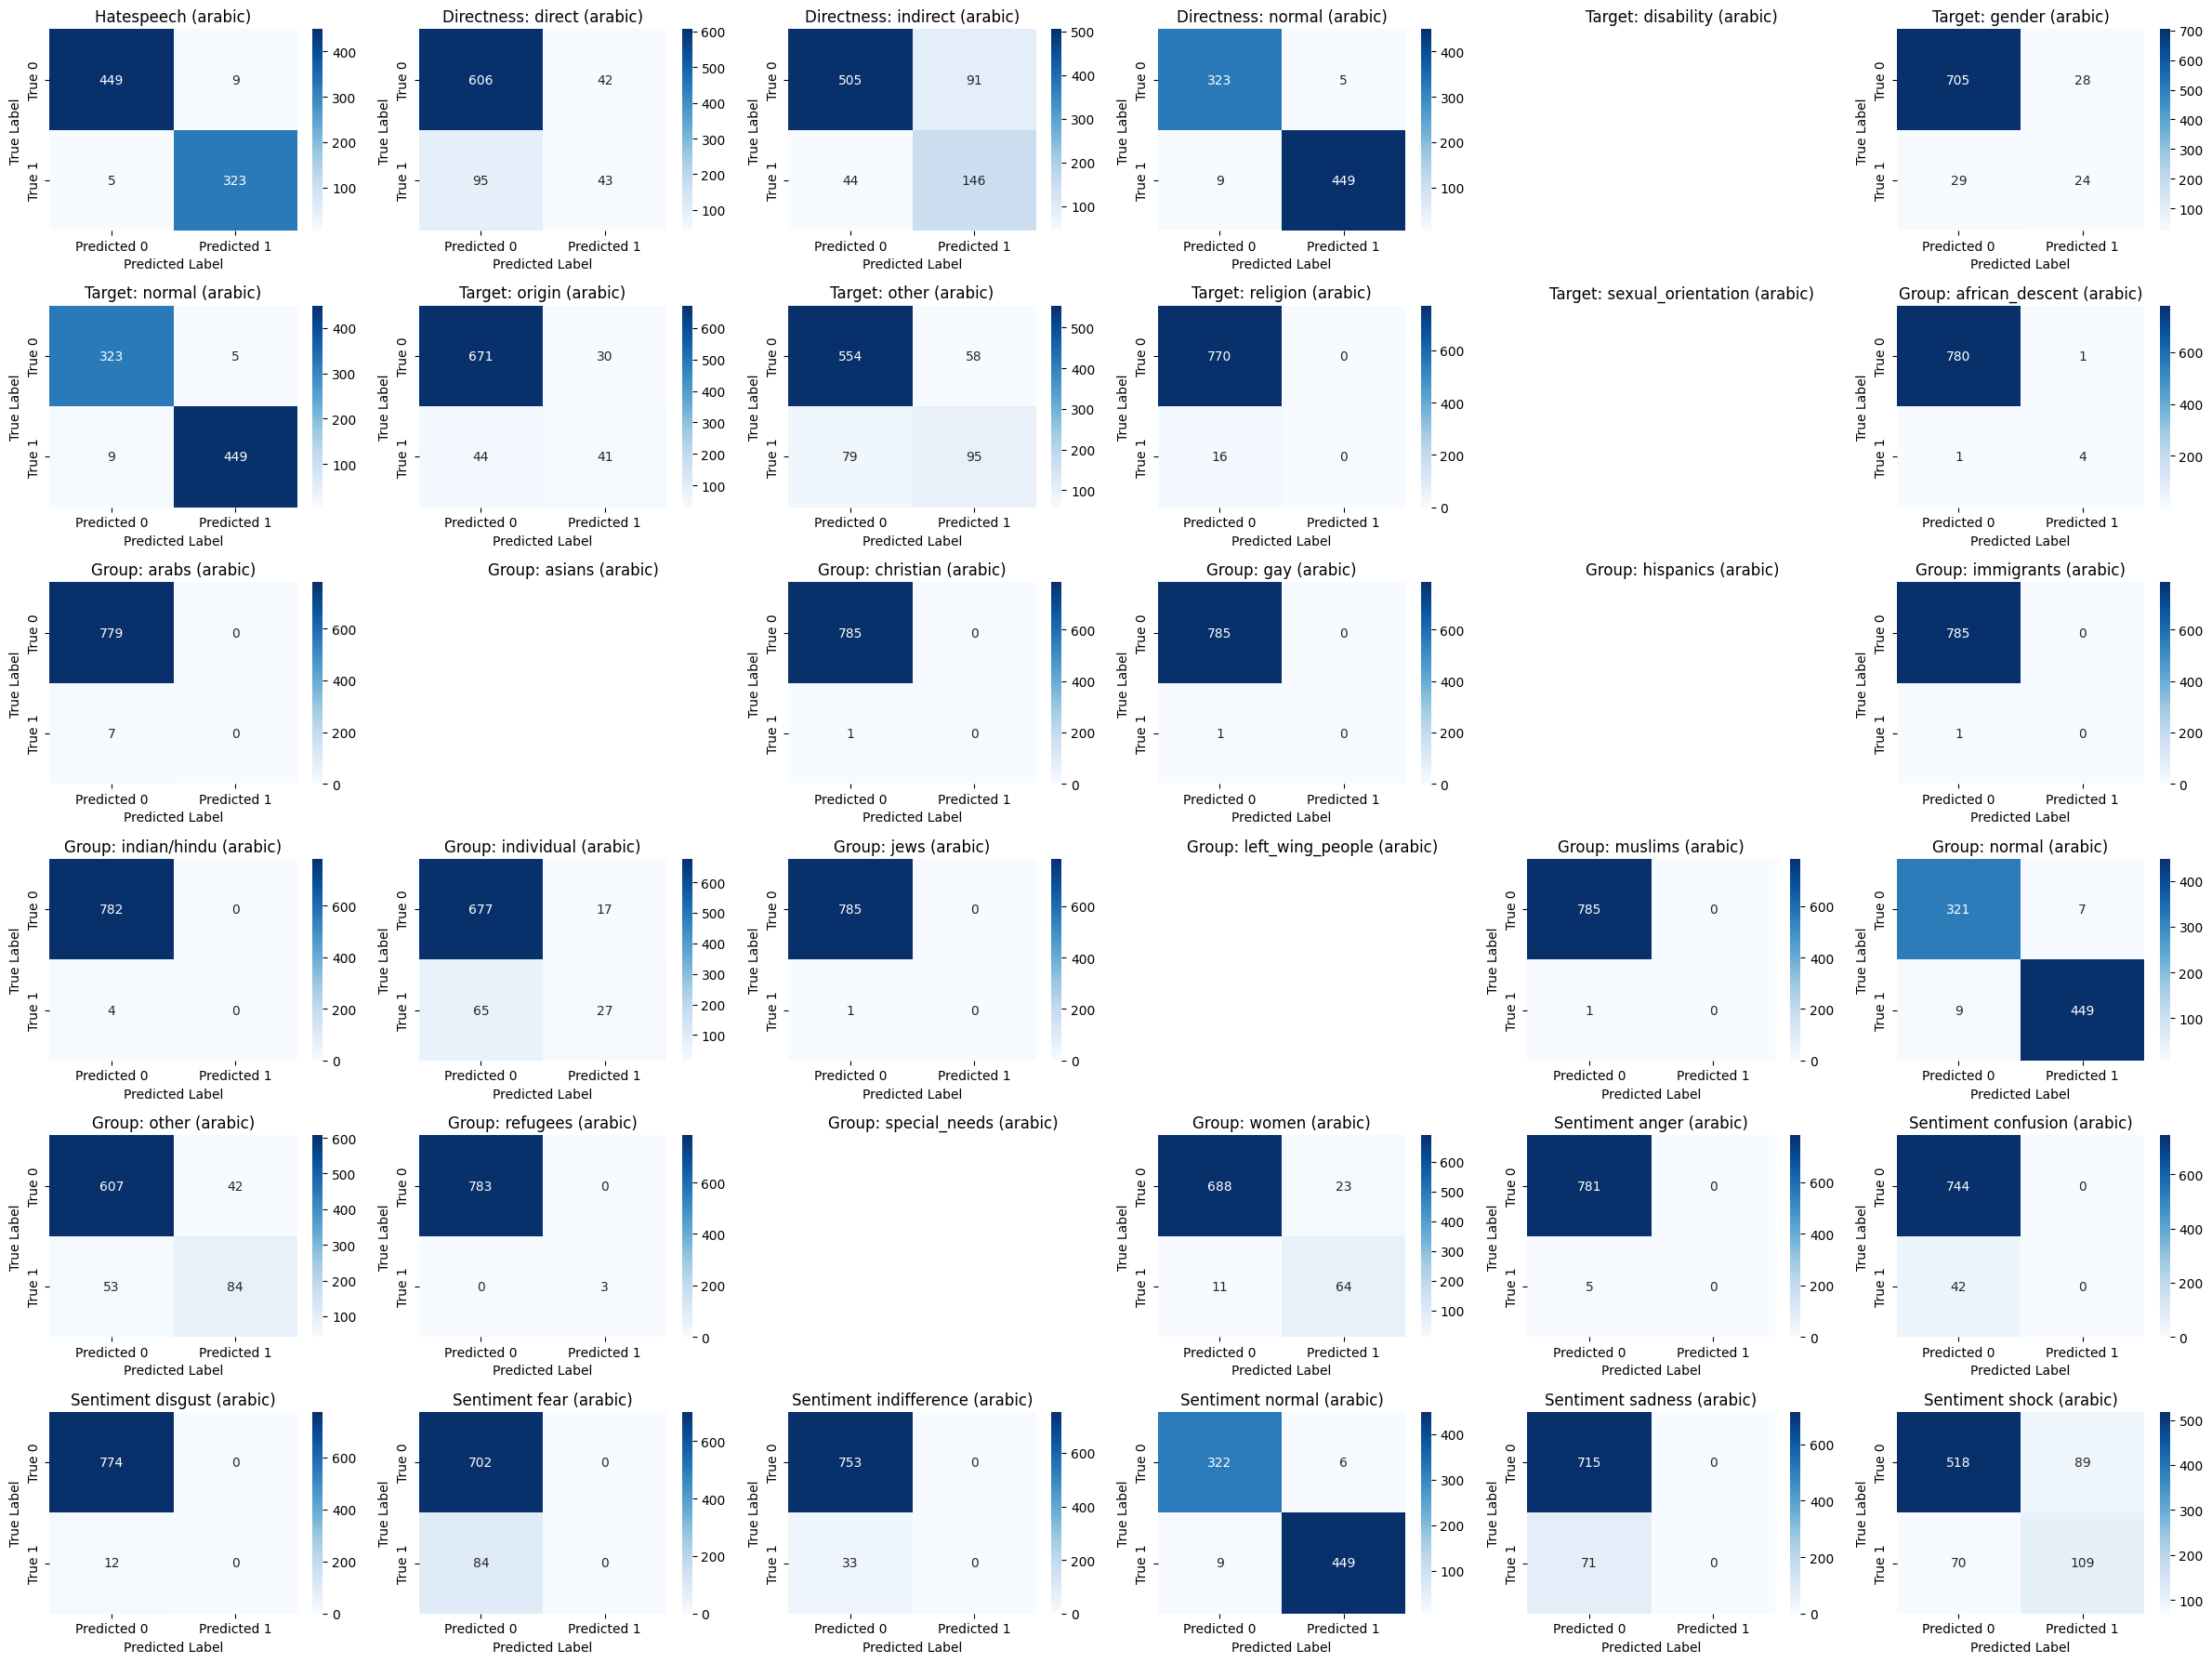


--- Analyzing english ---
Skipping group_label_3 in english: Only one true class present in true labels.


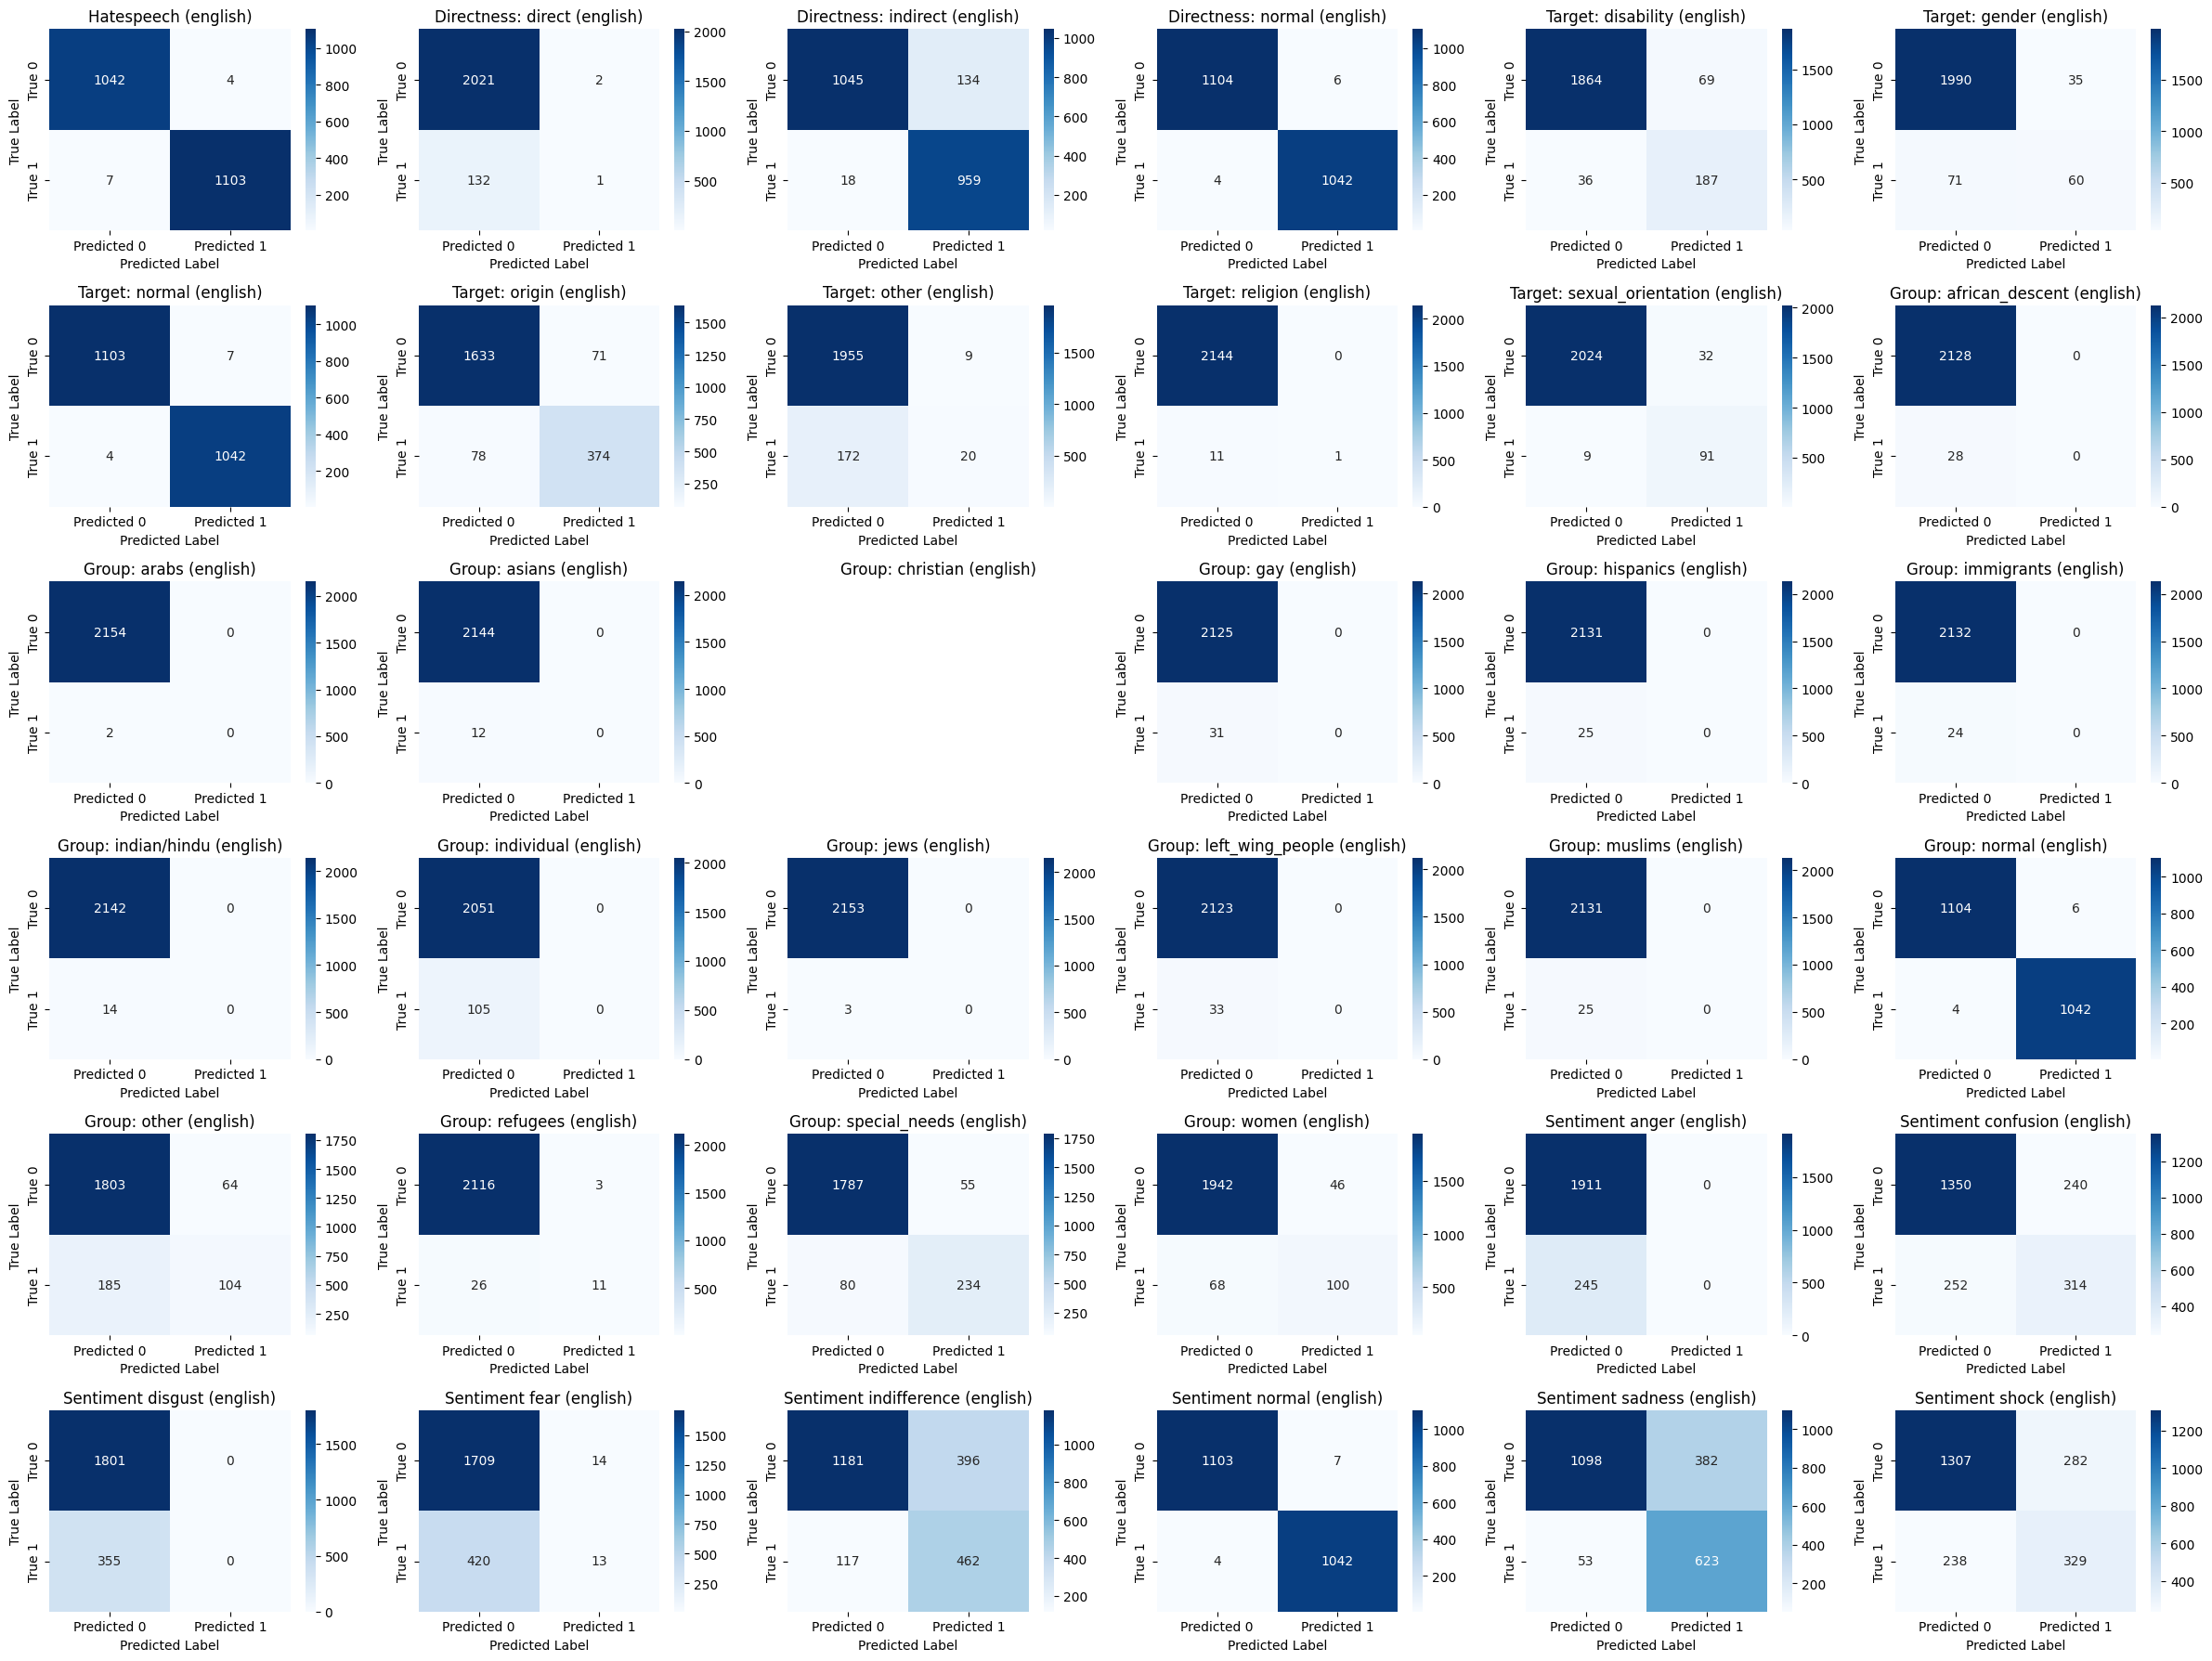


--- Analyzing french ---


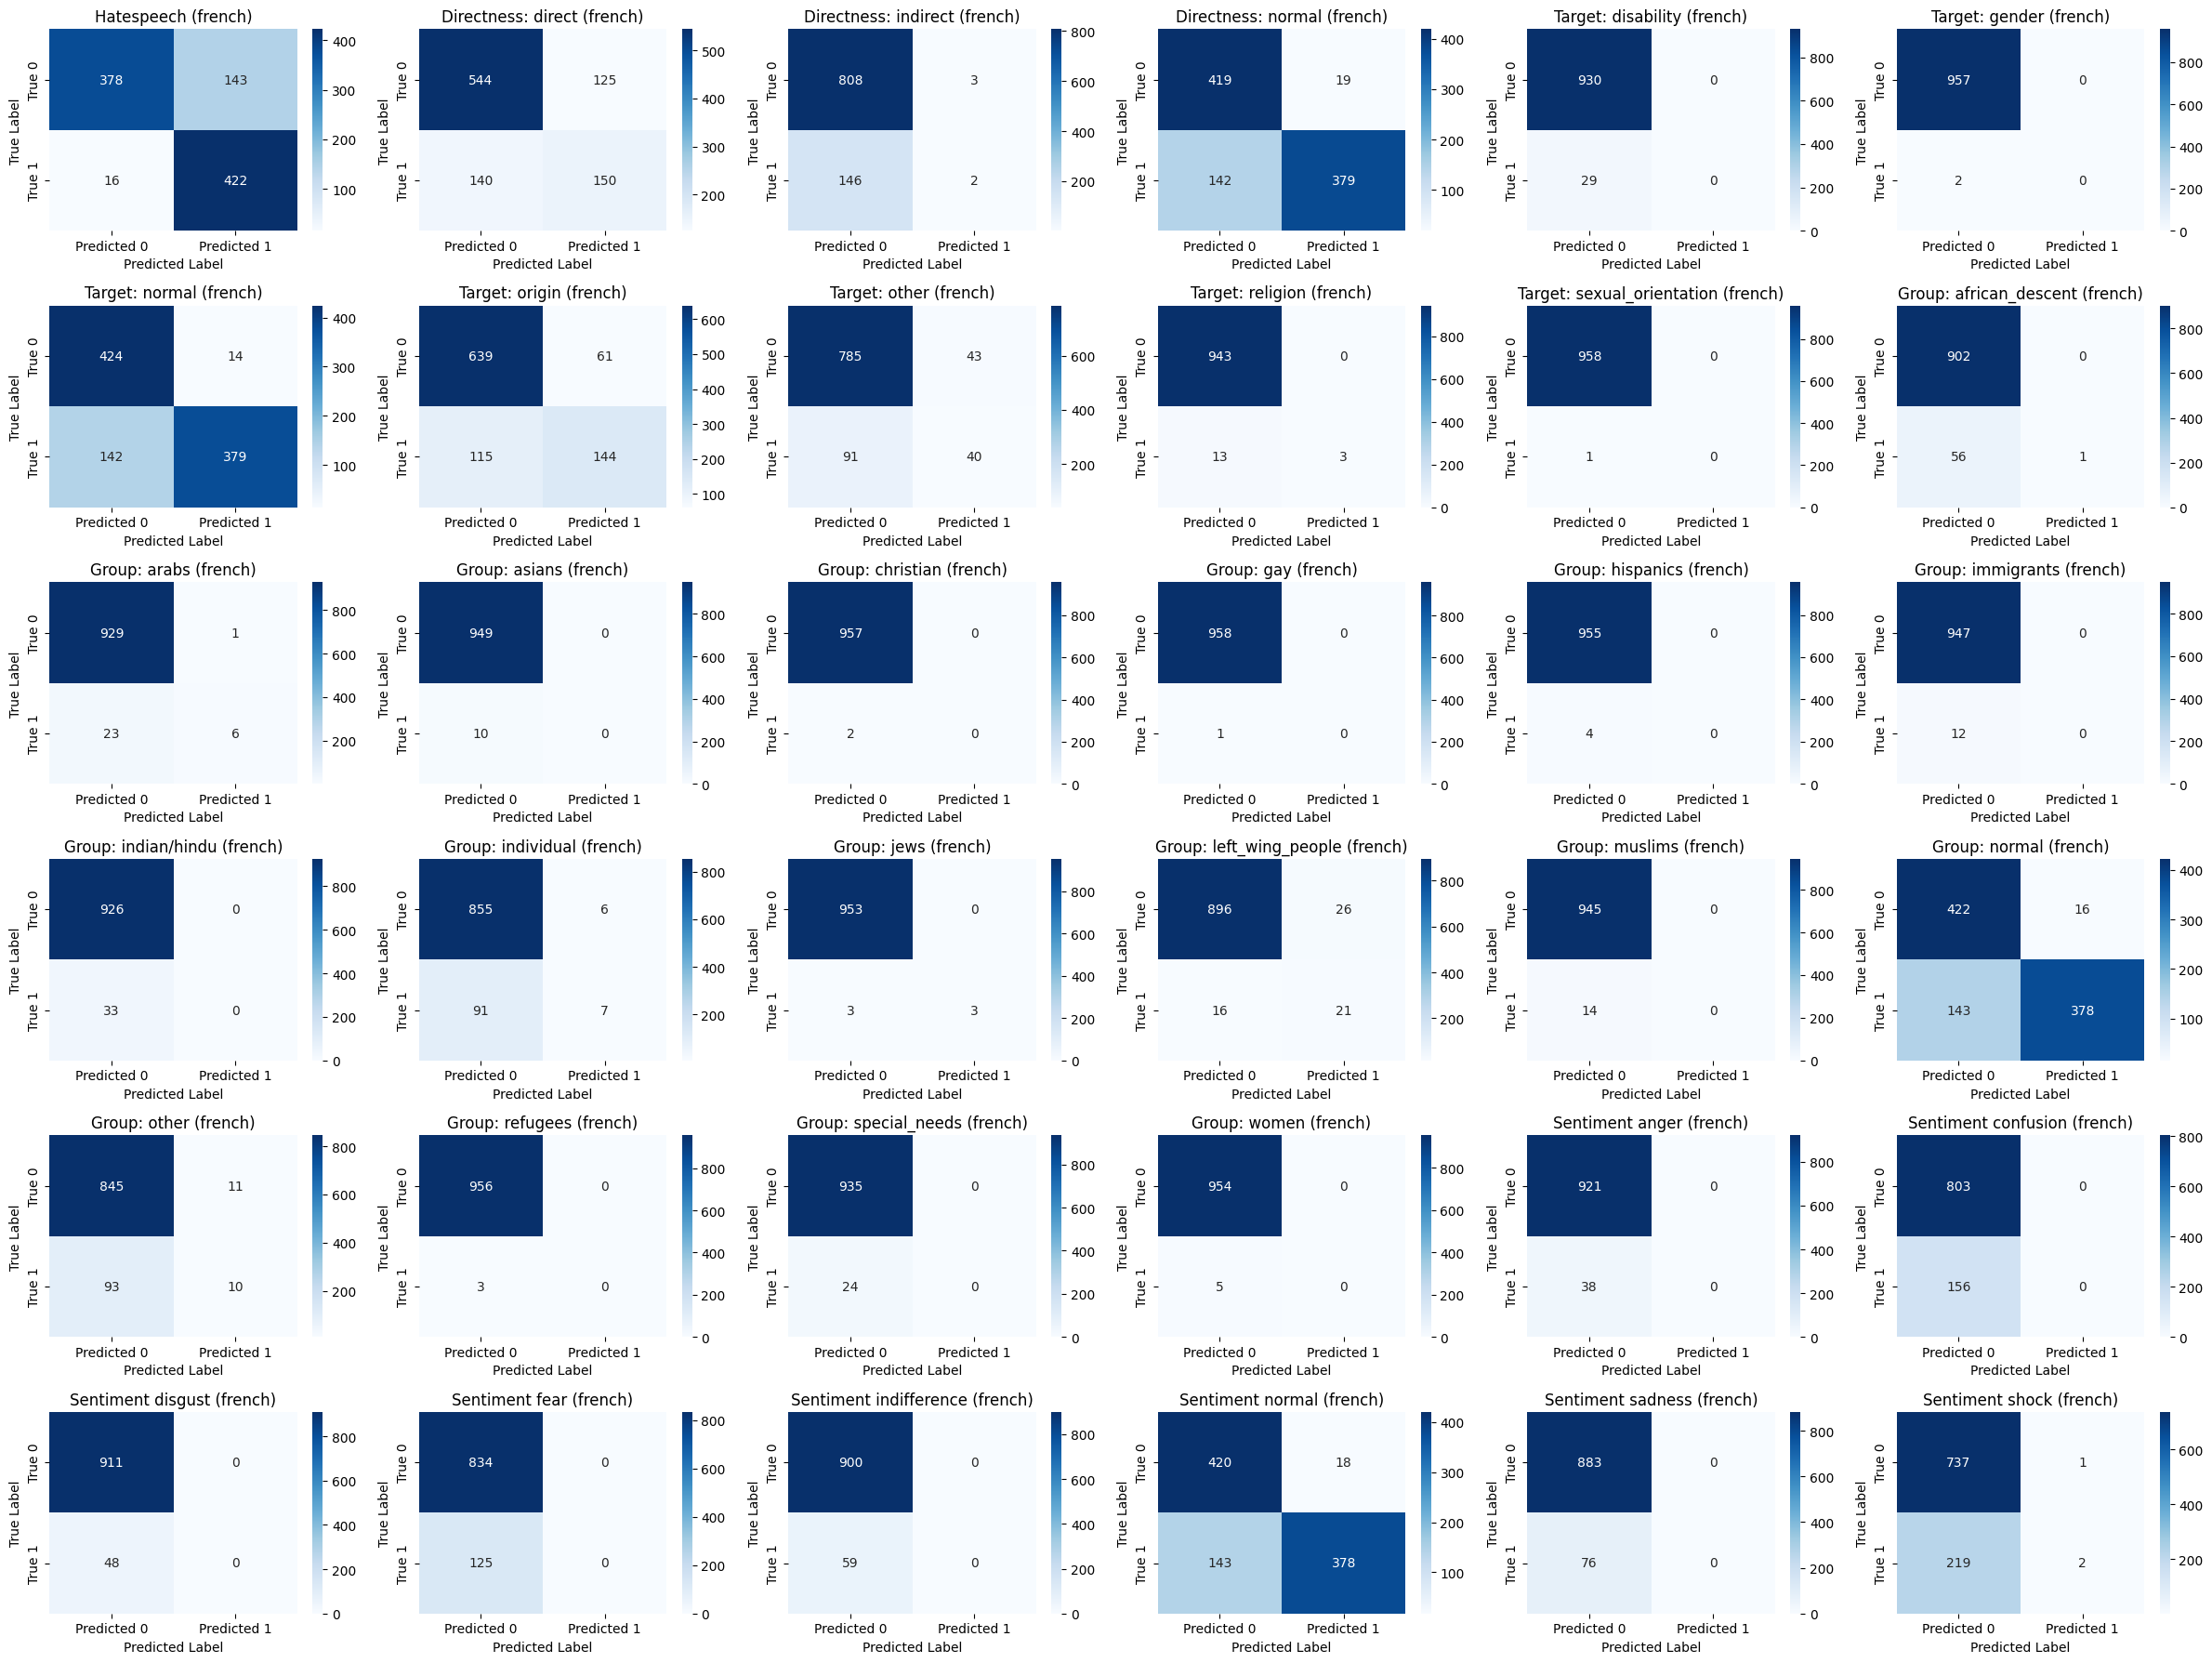

In [22]:
# Get predictions from the trainer
predictions = trainer.predict(encoded_dataset["validation"])

predicted_logits = predictions.predictions
true_labels_np = predictions.label_ids

# Apply sigmoid to get probabilities from logits
sigmoid = torch.nn.Sigmoid()
predicted_probs_np = sigmoid(torch.Tensor(predicted_logits)).numpy()

# Apply a threshold to get binary predictions
predicted_binary_labels_np = (predicted_probs_np >= 0.5).astype(int)

# Get the original language information for the validation dataset
val_languages = val_df['language'].values


# Define label name lists
sentiment_label_names = [
    "sentiment_anger",
    "sentiment_confusion",
    "sentiment_disgust",
    "sentiment_fear",
    "sentiment_indifference",
    "sentiment_normal",
    "sentiment_sadness",
    "sentiment_shock"
]
directness_label_names = [f'directness_label_{val}' for val in sorted(train_df['directness_label'].unique().tolist())]
target_label_names = [f'target_label_{val}' for val in sorted(train_df['target_label'].unique().tolist())]
group_label_names = [f'group_label_{val}' for val in sorted(train_df['group_label'].unique().tolist())]


# Get unique languages from the validation dataset
unique_languages = np.unique(val_languages)

# Define label categories and their corresponding lists of label names in the desired order
label_categories = {
    'hatespeech': ['hatespeech'],
    'directness': directness_label_names,
    'target': target_label_names,
    'group': group_label_names,
    'sentiment': sentiment_label_names,
}

# Define the mapping for multiclass labels to their descriptive names
multiclass_label_maps = {
    'directness': directness_map,
    'target': target_map,
    'group': group_map
}

# Function to plot confusion matrix (already defined, but including for clarity in this block)
def plot_confusion_matrix(cm, title, ax):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'], ax=ax)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title(title)

# Loop through each unique language
for lang in unique_languages:
    print(f"\n--- Analyzing {lang} ---")

    # Get indices for the current language in the validation dataset
    lang_indices = np.where(val_languages == lang)[0]

    # Calculate the total number of plots needed for this language
    total_plots_for_lang = sum(len(labels) for labels in label_categories.values())

    # Determine the grid size for subplots
    n_cols = 6  # Number of columns in the subplot grid
    n_rows = (total_plots_for_lang + n_cols - 1) // n_cols  # Calculate number of rows needed

    # Create a figure with subplots for this language
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    plot_index = 0 # Initialize plot index

    # Loop through each label category in the defined order
    for category_name, labels_list in label_categories.items():
        # Loop through each label within the category
        for label_name in labels_list:

            if plot_index < len(axes): # Ensure we don't exceed the number of subplots

                # Find the global index of this label in the all_binary_labels list
                try:
                    global_label_index = all_binary_labels.index(label_name)
                except ValueError:
                    print(f"Warning: Label '{label_name}' not found in all_binary_labels. Skipping.")
                    # Still add a placeholder title to the skipped plot if an axis is available
                    if plot_index < len(axes):
                         axes[plot_index].set_title(f'{label_name.replace("_", " ").capitalize()} ({lang}) - Data Missing')
                         axes[plot_index].axis('off') # Hide axis for empty plot
                    plot_index += 1
                    continue

                # Get the true and predicted binary labels for this specific label and language
                true_label_lang = true_labels_np[lang_indices, global_label_index]
                predicted_label_lang = predicted_binary_labels_np[lang_indices, global_label_index]

                # Determine the title for the plot
                if category_name in multiclass_label_maps and '_' in label_name:
                    # For multiclass labels, use the descriptive map
                    # Extract the original label value (e.g., '0' from 'directness_label_0')
                    parts = label_name.split('_')
                    original_value = parts[-1]
                    descriptive_name = multiclass_label_maps[category_name].get(original_value, original_value)
                    title = f'{category_name.capitalize()}: {descriptive_name} ({lang})'
                else:
                    # For binary/sentiment labels, use the label name directly
                    title = f'{label_name.replace("_", " ").capitalize()} ({lang})'

                # Check if there are at least two unique classes in the true labels
                if len(np.unique(true_label_lang)) < 2:
                    print(f"Skipping {label_name} in {lang}: Only one true class present in true labels.")
                    # Still add the title to the empty plot
                    if plot_index < len(axes):
                        axes[plot_index].set_title(title)
                        axes[plot_index].axis('off') # Hide axis for empty plot
                    plot_index += 1
                    continue


                # Calculate the confusion matrix
                cm_lang = confusion_matrix(true_label_lang, predicted_label_lang)

                # Plot the confusion matrix on the current subplot
                plot_confusion_matrix(cm_lang, title, axes[plot_index])

                plot_index += 1 # Increment plot index

    # Hide any unused subplots
    for k in range(plot_index, len(axes)):
        fig.delaxes(axes[k])

    plt.tight_layout()
    plt.show()

### Full Confusion Matrices Key Findings
- The model's performance on the "hatespeech" label is consistent across all three languages (Arabic, English, and French), with a high number of true negatives and relatively few misclassifications.
- For the "directness" category, the model performs well in identifying "direct" and "normal" speech across all languages. However, it struggles with "indirect" speech, particularly in English and French, where it often misclassifies it.
- In the "target" category, the model shows varied performance. It is effective at identifying "normal" speech and some specific targets like "gender" and "sexual orientation" in English. However, for many other target categories across all languages, the data is sparse, leading to many empty or single-class plots.
- The "group" category suffers from significant data sparsity. While the model correctly identifies "normal" instances, most other group-specific labels lack sufficient data in the validation set for a meaningful performance evaluation, resulting in many skipped plots.
- For "sentiment," the model is highly effective at identifying "neutral" and "negative" sentiment across all languages. It shows some confusion with "positive" sentiment, especially in English and French, but the overall performance is strong.

### Insights or Next Steps
- Given the data sparsity for many "target" and "group" labels, it would be beneficial to either collect more data for these specific categories or consider grouping some of the less frequent labels to create more balanced classes for model training and evaluation.
- The model's difficulty in distinguishing "indirect" hate speech suggests that this is a challenging area. Future work could focus on feature engineering or using more advanced models specifically designed to understand nuanced and indirect language.


### Flattened Confusion Matrices


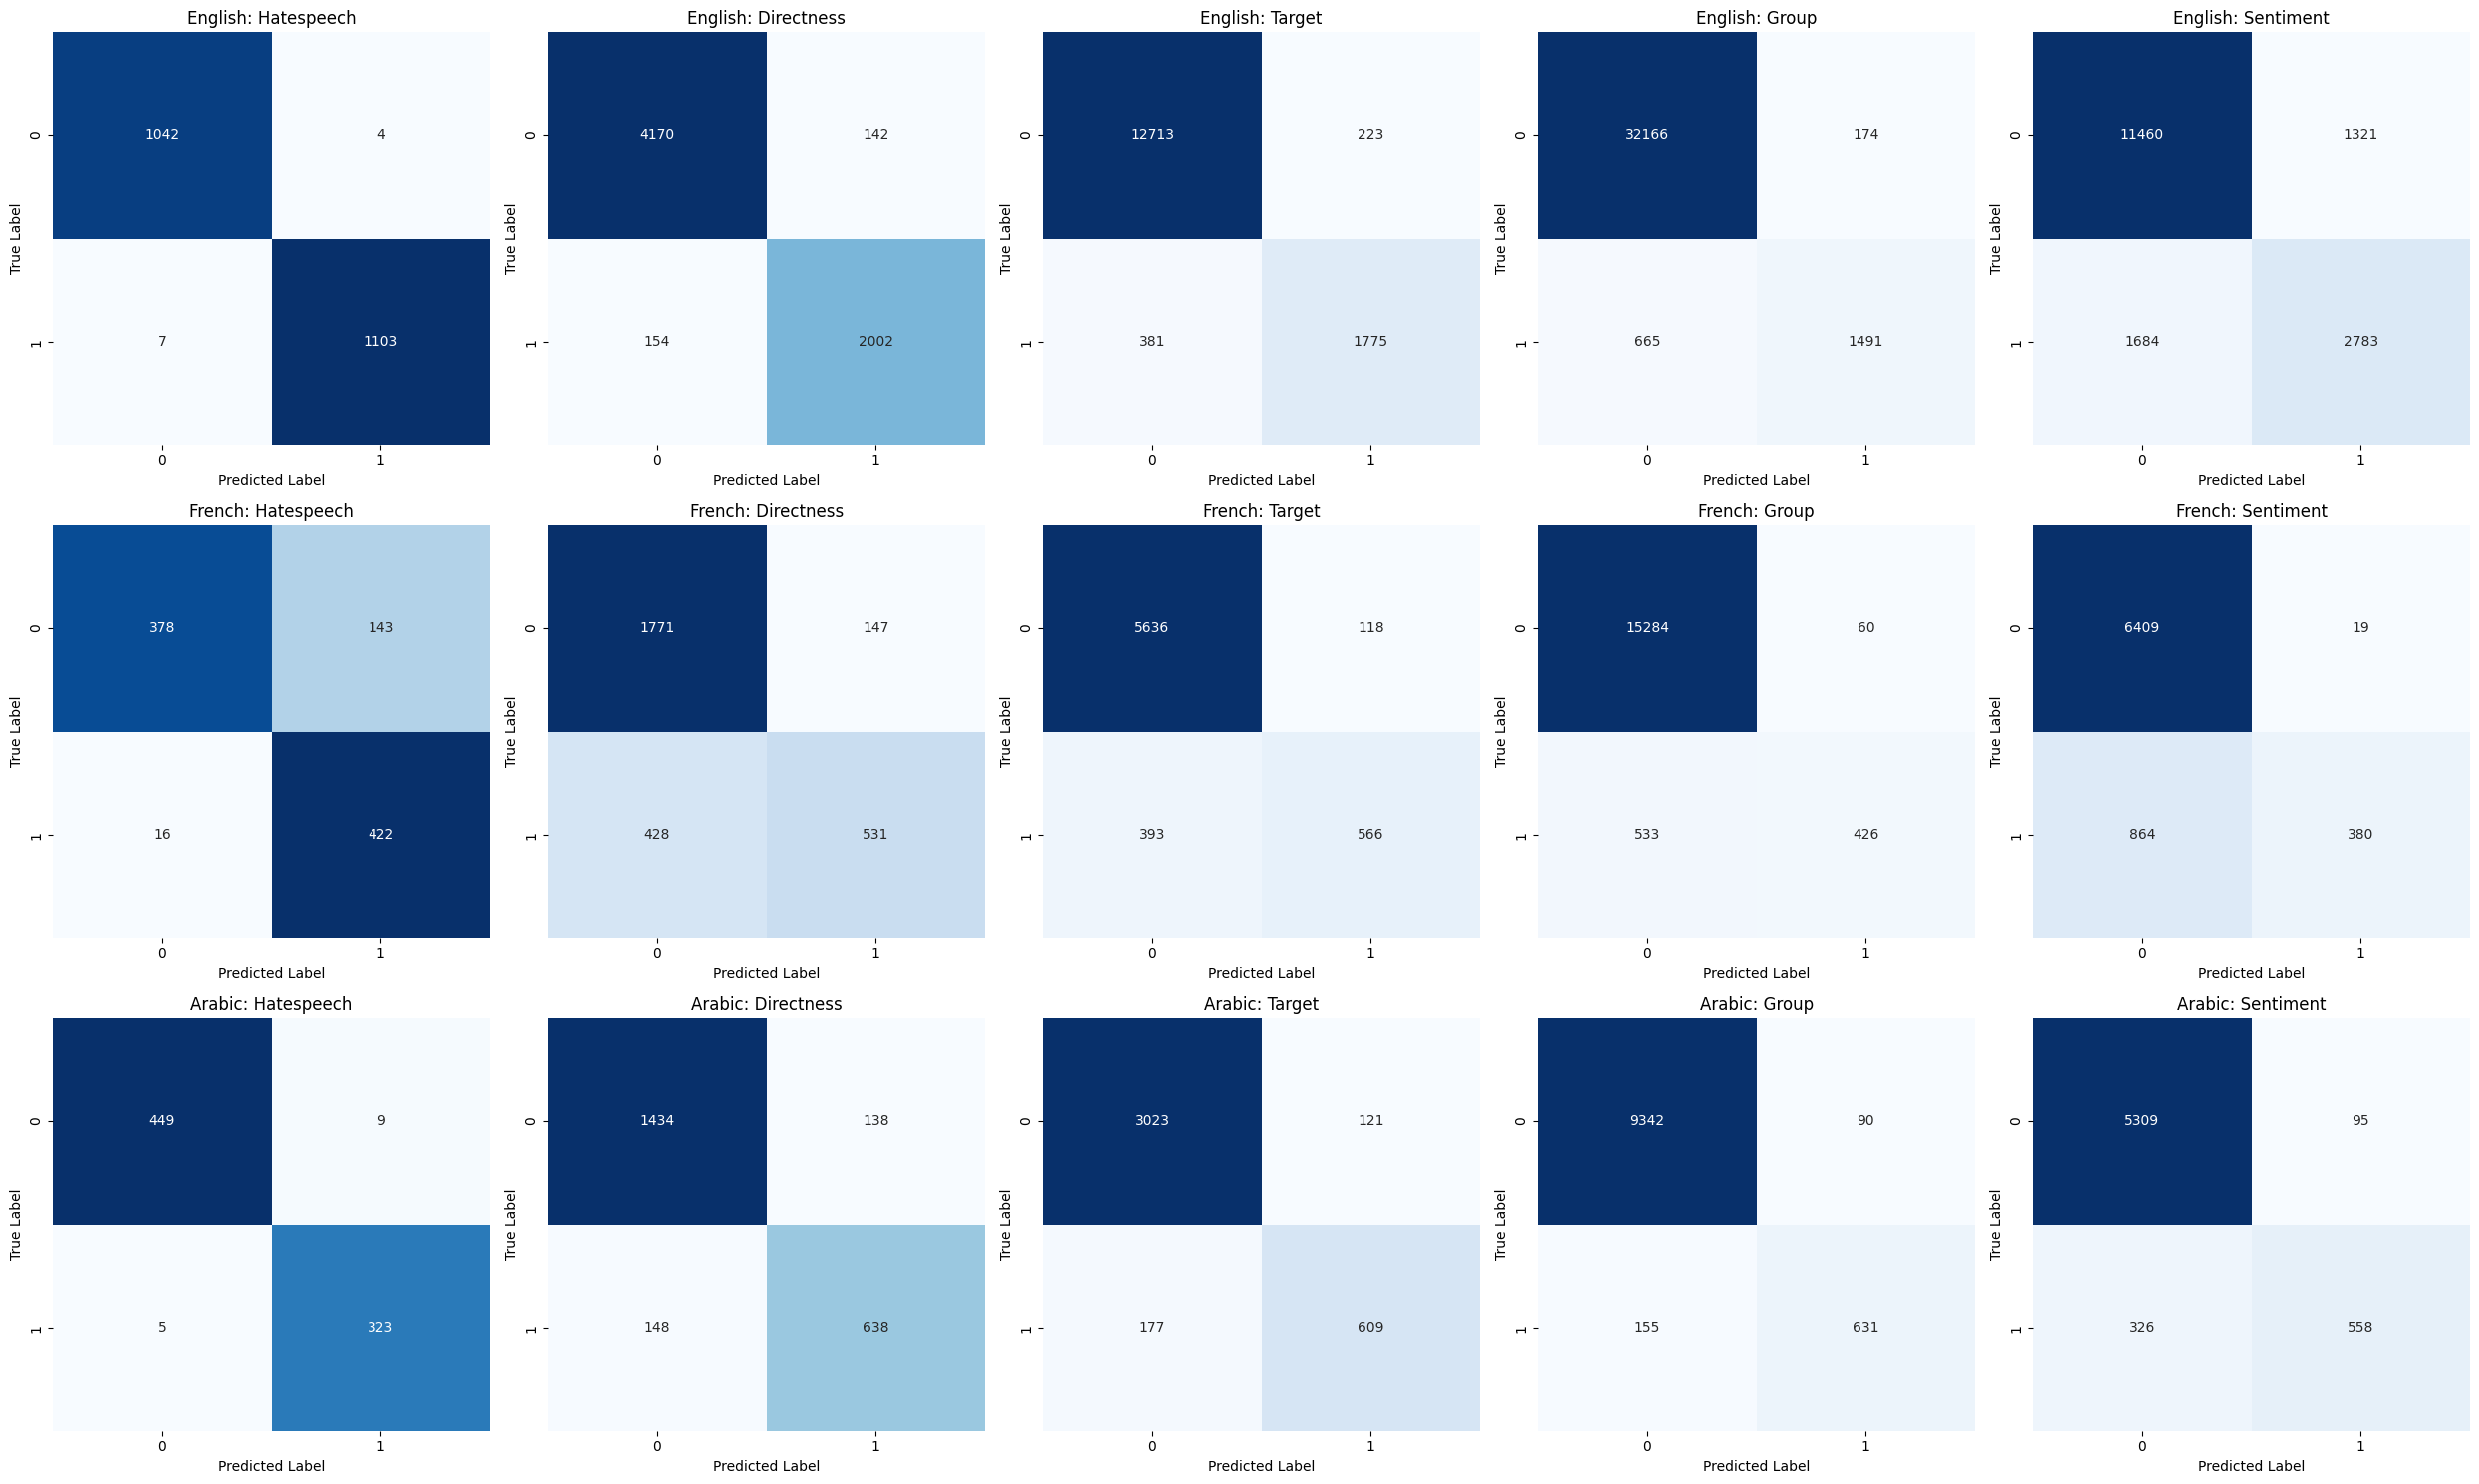

In [23]:
# Define the order of languages and label categories
language_order = ['english', 'french', 'arabic']
category_order = ['hatespeech', 'directness', 'target', 'group', 'sentiment']

# Create a figure and a 3x5 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15))

# Iterate through each language for the rows
for row_idx, lang in enumerate(language_order):
    # Iterate through each label category for the columns
    for col_idx, category_name in enumerate(category_order):
        ax = axes[row_idx, col_idx]

        # Initialize a flattened confusion matrix for the category
        flattened_cm = np.zeros((2, 2), dtype=int)

        # Get the list of labels for the current category
        labels_in_category = label_categories[category_name]

        # Get indices for the current language
        lang_indices = np.where(val_languages == lang)[0]

        # Iterate through each label within the category to aggregate the CM
        for label_name in labels_in_category:
            try:
                global_label_index = all_binary_labels.index(label_name)
            except ValueError:
                continue  # Skip if label not found

            true_label_lang = true_labels_np[lang_indices, global_label_index]
            predicted_label_lang = predicted_binary_labels_np[lang_indices, global_label_index]

            if len(np.unique(true_label_lang)) < 2:
                # Still need to handle the case where a plot is "empty"
                # but we continue to sum up for the flattened view
                continue

            cm_individual = confusion_matrix(true_label_lang, predicted_label_lang, labels=[0, 1])
            flattened_cm += cm_individual

        # Plot the flattened confusion matrix
        sns.heatmap(flattened_cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
        ax.set_title(f'{lang.capitalize()}: {category_name.capitalize()}')
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')

plt.tight_layout()
plt.show()

### Flattened Confusion Matrix Key Findings
*   A 3x5 grid of flattened confusion matrices was successfully generated, comparing the model's performance across three languages (English, French, and Arabic) and five label categories (hatespeech, directness, target, group, and sentiment).
*   Each subplot in the grid displays an aggregated confusion matrix for a specific language-category pair, offering a clear overview of the model's predictive accuracy in various contexts.
*   The visualizations are well-organized, with each plot correctly titled, providing a solid basis for analyzing the model's performance and understanding the performance differences between the non-hierarchical and hierarchical models.

### Insights or Next Steps
*   The generated flattened confusion matrices can be used to conduct a detailed error analysis for each language and label category, identifying specific areas where the model struggles.
*   Further investigation could involve comparing these confusion matrices with those from the hierarchical model to pinpoint the exact reasons for the performance discrepancy.


## LIME Explanations by Language and Category

Show correct and incorrect predictions for each label, for each category, for each language.

In [24]:
!pip install -q lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 17.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [25]:
import lime
from lime import lime_text
import numpy as np

def lime_predictor(texts, label_index):
    """
    LIME predictor function for a specific label.

    Args:
        texts (list of str): A list of text strings to predict.
        label_index (int): The index of the target label.

    Returns:
        np.ndarray: A NumPy array of probabilities for the specified label.
    """
    # Tokenize the input texts
    encoding = tokenizer(texts, return_tensors="pt", padding="max_length", truncation=True, max_length=150)
    # Move tensors to the same device as the model
    encoding = {k: v.to(model.device) for k, v in encoding.items()}

    # Get predictions from the model
    with torch.no_grad():
        outputs = model(**encoding)

    # Apply sigmoid to get probabilities
    logits = outputs.logits
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(logits).cpu().numpy()

    # Return the probabilities for the specified label index
    # and for the positive class (1)
    return np.array([1 - probs[:, label_index], probs[:, label_index]]).T

In [26]:
explainer = lime_text.LimeTextExplainer(class_names=['not_label', 'is_label'])

# Store examples for explanation, with more specific categories
explanation_examples = {}

for lang in language_order:
    explanation_examples[lang] = {}
    for category_name in category_order:
        explanation_examples[lang][category_name] = {}

        labels_in_category = label_categories[category_name]
        lang_indices = np.where(val_languages == lang)[0]

        for label_name in labels_in_category:
            explanation_examples[lang][category_name][label_name] = {
                'correct_is_label': None,
                'correct_not_label': None,
                'incorrect_is_label': None, # False Positive
                'incorrect_not_label': None  # False Negative
            }

            try:
                global_label_index = all_binary_labels.index(label_name)
            except ValueError:
                continue

            true_label_lang = true_labels_np[lang_indices, global_label_index]
            predicted_label_lang = predicted_binary_labels_np[lang_indices, global_label_index]

            # Correctly predicted "is_label" (True Positive)
            correct_is_label_indices = np.where((true_label_lang == 1) & (predicted_label_lang == 1))[0]
            if len(correct_is_label_indices) > 0:
                example_idx = lang_indices[correct_is_label_indices[0]]
                explanation_examples[lang][category_name][label_name]['correct_is_label'] = {
                    'text': val_df.iloc[example_idx]['text_cleaned'],
                    'label_index': global_label_index
                }

            # Correctly predicted "not_label" (True Negative)
            correct_not_label_indices = np.where((true_label_lang == 0) & (predicted_label_lang == 0))[0]
            if len(correct_not_label_indices) > 0:
                example_idx = lang_indices[correct_not_label_indices[0]]
                explanation_examples[lang][category_name][label_name]['correct_not_label'] = {
                    'text': val_df.iloc[example_idx]['text_cleaned'],
                    'label_index': global_label_index
                }

            # Incorrectly predicted "is_label" (False Positive)
            incorrect_is_label_indices = np.where((true_label_lang == 0) & (predicted_label_lang == 1))[0]
            if len(incorrect_is_label_indices) > 0:
                example_idx = lang_indices[incorrect_is_label_indices[0]]
                explanation_examples[lang][category_name][label_name]['incorrect_is_label'] = {
                    'text': val_df.iloc[example_idx]['text_cleaned'],
                    'label_index': global_label_index
                }

            # Incorrectly predicted "not_label" (False Negative)
            incorrect_not_label_indices = np.where((true_label_lang == 1) & (predicted_label_lang == 0))[0]
            if len(incorrect_not_label_indices) > 0:
                example_idx = lang_indices[incorrect_not_label_indices[0]]
                explanation_examples[lang][category_name][label_name]['incorrect_not_label'] = {
                    'text': val_df.iloc[example_idx]['text_cleaned'],
                    'label_index': global_label_index
                }


print("Explanation examples have been collected for each label and prediction type.")

Explanation examples have been collected for each label and prediction type.


#### Show correct and incorrect predictions for each label, for each category, for each language.

In [27]:
import torch
torch.cuda.empty_cache()

# Move the model to CUDA (as requested by the user, assuming CUDA is available)
if torch.cuda.is_available():
    model.to('cuda')
    device = 'cuda'
else:
    model.to('cpu')
    device = 'cpu'

def lime_predictor(texts, label_index):
    """
    LIME predictor function for a specific label.
    Ensures tensors are on the same device as the model.
    """
    encoding = tokenizer(texts, return_tensors="pt", padding="max_length", truncation=True, max_length=150)
    # Move encoding tensors to the same device as the model
    encoding = {k: v.to(model.device) for k, v in encoding.items()}

    with torch.no_grad():
        outputs = model(**encoding)

    logits = outputs.logits
    sigmoid = torch.nn.Sigmoid()
    # Move logits to CPU for numpy conversion
    probs = sigmoid(logits).cpu().numpy()

    return np.array([1 - probs[:, label_index], probs[:, label_index]]).T

# Assuming explainer and multiclass_label_maps are defined in previous cells
# explainer = lime_text.LimeTextExplainer(class_names=['not_label', 'is_label'])
# multiclass_label_maps = { ... }

## LIME Explanations by Language and Category

In [28]:
from IPython.display import display, Markdown

def display_lime_explanations(lang, category_name, explanation_examples, label_categories, multiclass_label_maps, explainer, lime_predictor):
    """
    Displays LIME explanations for different prediction cases for a given language and category.

    Args:
        lang (str): The language of the examples.
        category_name (str): The name of the label category.
        explanation_examples (dict): Dictionary containing collected explanation examples.
        label_categories (dict): Dictionary mapping category names to label lists.
        multiclass_label_maps (dict): Dictionary mapping multiclass categories to descriptive label names.
        explainer (lime_text.LimeTextExplainer): The LIME explainer object.
        lime_predictor (function): The LIME predictor function.
    """
    labels_in_category = label_categories[category_name]

    # Find the first label in the category with examples
    first_label_with_examples = None
    for label_name in labels_in_category:
        if explanation_examples[lang][category_name][label_name]['correct_is_label'] or \
           explanation_examples[lang][category_name][label_name]['correct_not_label'] or \
           explanation_examples[lang][category_name][label_name]['incorrect_is_label'] or \
           explanation_examples[lang][category_name][label_name]['incorrect_not_label']:
            first_label_with_examples = label_name
            break

    if first_label_with_examples:
        label_name = first_label_with_examples
        examples = explanation_examples[lang][category_name][label_name]

        for case, example_data in examples.items():
            if example_data:
                text = example_data['text']
                label_index = example_data['label_index']

                # Determine the display title for the label
                display_label_name = label_name
                if category_name in multiclass_label_maps and '_' in label_name:
                    parts = label_name.split('_')
                    original_value = parts[-1]
                    descriptive_name = multiclass_label_maps[category_name].get(original_value, original_value)
                    display_label_name = f"{category_name.capitalize()}: {descriptive_name}"
                else:
                    display_label_name = label_name.replace("_", " ").capitalize()

                # Generate markdown subheading for the label and language
                markdown_heading = f"#### {display_label_name} ({case.capitalize()})"
                display(Markdown(markdown_heading))

                print(f"Generating explanation for: {lang.capitalize()} - {display_label_name} ({case.capitalize()})")

                try:
                    explanation = explainer.explain_instance(
                        text,
                        lambda x: lime_predictor(x, label_index),
                        num_features=10,
                        num_samples=500,
                        labels=(1,) # Explain for the positive class
                    )

                    print(f"--- {lang.capitalize()}: {display_label_name} ({case.capitalize()}) ---")
                    display(explanation.show_in_notebook(text=True))

                except Exception as e:
                    print(f"Could not generate explanation for {label_name} ({case}) in {lang}: {e}")
                    continue
    else:
        display(Markdown(f"#### No examples found for {category_name} in {lang}"))

## English

### English - Hatespeech LIME Explanations

In [29]:
display_lime_explanations(
    lang='english',
    category_name='hatespeech',
    explanation_examples=explanation_examples,
    label_categories=label_categories,
    multiclass_label_maps=multiclass_label_maps,
    explainer=explainer,
    lime_predictor=lime_predictor
)

#### Hatespeech (Correct_is_label)

Generating explanation for: English - Hatespeech (Correct_is_label)
Could not generate explanation for hatespeech (correct_is_label) in english: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


#### Hatespeech (Correct_not_label)

Generating explanation for: English - Hatespeech (Correct_not_label)
Could not generate explanation for hatespeech (correct_not_label) in english: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


#### Hatespeech (Incorrect_is_label)

Generating explanation for: English - Hatespeech (Incorrect_is_label)
Could not generate explanation for hatespeech (incorrect_is_label) in english: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


#### Hatespeech (Incorrect_not_label)

Generating explanation for: English - Hatespeech (Incorrect_not_label)
Could not generate explanation for hatespeech (incorrect_not_label) in english: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


### English - Directness LIME Explanations

In [30]:
display_lime_explanations(
    lang='english',
    category_name='directness',
    explanation_examples=explanation_examples,
    label_categories=label_categories,
    multiclass_label_maps=multiclass_label_maps,
    explainer=explainer,
    lime_predictor=lime_predictor
)

#### Directness: direct (Correct_is_label)

Generating explanation for: English - Directness: direct (Correct_is_label)
Could not generate explanation for directness_label_0 (correct_is_label) in english: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


#### Directness: direct (Correct_not_label)

Generating explanation for: English - Directness: direct (Correct_not_label)
Could not generate explanation for directness_label_0 (correct_not_label) in english: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


#### Directness: direct (Incorrect_is_label)

Generating explanation for: English - Directness: direct (Incorrect_is_label)
Could not generate explanation for directness_label_0 (incorrect_is_label) in english: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


#### Directness: direct (Incorrect_not_label)

Generating explanation for: English - Directness: direct (Incorrect_not_label)
Could not generate explanation for directness_label_0 (incorrect_not_label) in english: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


### English - Target LIME Explanations

In [31]:
display_lime_explanations(
    lang='english',
    category_name='target',
    explanation_examples=explanation_examples,
    label_categories=label_categories,
    multiclass_label_maps=multiclass_label_maps,
    explainer=explainer,
    lime_predictor=lime_predictor
)

#### Target: disability (Correct_is_label)

Generating explanation for: English - Target: disability (Correct_is_label)
Could not generate explanation for target_label_0 (correct_is_label) in english: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


#### Target: disability (Correct_not_label)

Generating explanation for: English - Target: disability (Correct_not_label)
Could not generate explanation for target_label_0 (correct_not_label) in english: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


#### Target: disability (Incorrect_is_label)

Generating explanation for: English - Target: disability (Incorrect_is_label)
Could not generate explanation for target_label_0 (incorrect_is_label) in english: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


#### Target: disability (Incorrect_not_label)

Generating explanation for: English - Target: disability (Incorrect_not_label)
Could not generate explanation for target_label_0 (incorrect_not_label) in english: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


### English - Group LIME Explanations

In [32]:
display_lime_explanations(
    lang='english',
    category_name='group',
    explanation_examples=explanation_examples,
    label_categories=label_categories,
    multiclass_label_maps=multiclass_label_maps,
    explainer=explainer,
    lime_predictor=lime_predictor
)

#### Group: african_descent (Correct_not_label)

Generating explanation for: English - Group: african_descent (Correct_not_label)
Could not generate explanation for group_label_0 (correct_not_label) in english: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


#### Group: african_descent (Incorrect_not_label)

Generating explanation for: English - Group: african_descent (Incorrect_not_label)
Could not generate explanation for group_label_0 (incorrect_not_label) in english: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


### English - Sentiment LIME Explanations

In [33]:
display_lime_explanations(
    lang='english',
    category_name='sentiment',
    explanation_examples=explanation_examples,
    label_categories=label_categories,
    multiclass_label_maps=multiclass_label_maps,
    explainer=explainer,
    lime_predictor=lime_predictor
)

#### Sentiment anger (Correct_not_label)

Generating explanation for: English - Sentiment anger (Correct_not_label)
Could not generate explanation for sentiment_anger (correct_not_label) in english: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


#### Sentiment anger (Incorrect_not_label)

Generating explanation for: English - Sentiment anger (Incorrect_not_label)
Could not generate explanation for sentiment_anger (incorrect_not_label) in english: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


## French

### French - Hatespeech LIME Explanations

In [34]:
display_lime_explanations(
    lang='french',
    category_name='hatespeech',
    explanation_examples=explanation_examples,
    label_categories=label_categories,
    multiclass_label_maps=multiclass_label_maps,
    explainer=explainer,
    lime_predictor=lime_predictor
)

#### Hatespeech (Correct_is_label)

Generating explanation for: French - Hatespeech (Correct_is_label)
Could not generate explanation for hatespeech (correct_is_label) in french: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


#### Hatespeech (Correct_not_label)

Generating explanation for: French - Hatespeech (Correct_not_label)
Could not generate explanation for hatespeech (correct_not_label) in french: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


#### Hatespeech (Incorrect_is_label)

Generating explanation for: French - Hatespeech (Incorrect_is_label)
Could not generate explanation for hatespeech (incorrect_is_label) in french: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


#### Hatespeech (Incorrect_not_label)

Generating explanation for: French - Hatespeech (Incorrect_not_label)
Could not generate explanation for hatespeech (incorrect_not_label) in french: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


### French - Directness LIME Explanations

In [35]:
display_lime_explanations(
    lang='french',
    category_name='directness',
    explanation_examples=explanation_examples,
    label_categories=label_categories,
    multiclass_label_maps=multiclass_label_maps,
    explainer=explainer,
    lime_predictor=lime_predictor
)

#### Directness: direct (Correct_is_label)

Generating explanation for: French - Directness: direct (Correct_is_label)
Could not generate explanation for directness_label_0 (correct_is_label) in french: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


#### Directness: direct (Correct_not_label)

Generating explanation for: French - Directness: direct (Correct_not_label)
Could not generate explanation for directness_label_0 (correct_not_label) in french: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


#### Directness: direct (Incorrect_is_label)

Generating explanation for: French - Directness: direct (Incorrect_is_label)
Could not generate explanation for directness_label_0 (incorrect_is_label) in french: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


#### Directness: direct (Incorrect_not_label)

Generating explanation for: French - Directness: direct (Incorrect_not_label)
Could not generate explanation for directness_label_0 (incorrect_not_label) in french: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


### French - Target LIME Explanations

In [36]:
display_lime_explanations(
    lang='french',
    category_name='target',
    explanation_examples=explanation_examples,
    label_categories=label_categories,
    multiclass_label_maps=multiclass_label_maps,
    explainer=explainer,
    lime_predictor=lime_predictor
)

#### Target: disability (Correct_not_label)

Generating explanation for: French - Target: disability (Correct_not_label)
Could not generate explanation for target_label_0 (correct_not_label) in french: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


#### Target: disability (Incorrect_not_label)

Generating explanation for: French - Target: disability (Incorrect_not_label)
Could not generate explanation for target_label_0 (incorrect_not_label) in french: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


### French - Group LIME Explanations

In [37]:
display_lime_explanations(
    lang='french',
    category_name='group',
    explanation_examples=explanation_examples,
    label_categories=label_categories,
    multiclass_label_maps=multiclass_label_maps,
    explainer=explainer,
    lime_predictor=lime_predictor
)

#### Group: african_descent (Correct_is_label)

Generating explanation for: French - Group: african_descent (Correct_is_label)
Could not generate explanation for group_label_0 (correct_is_label) in french: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


#### Group: african_descent (Correct_not_label)

Generating explanation for: French - Group: african_descent (Correct_not_label)
Could not generate explanation for group_label_0 (correct_not_label) in french: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


#### Group: african_descent (Incorrect_not_label)

Generating explanation for: French - Group: african_descent (Incorrect_not_label)
Could not generate explanation for group_label_0 (incorrect_not_label) in french: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


### French - Sentiment LIME Explanations

In [38]:
display_lime_explanations(
    lang='french',
    category_name='sentiment',
    explanation_examples=explanation_examples,
    label_categories=label_categories,
    multiclass_label_maps=multiclass_label_maps,
    explainer=explainer,
    lime_predictor=lime_predictor
)

#### Sentiment anger (Correct_not_label)

Generating explanation for: French - Sentiment anger (Correct_not_label)
Could not generate explanation for sentiment_anger (correct_not_label) in french: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


#### Sentiment anger (Incorrect_not_label)

Generating explanation for: French - Sentiment anger (Incorrect_not_label)
Could not generate explanation for sentiment_anger (incorrect_not_label) in french: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


## Arabic

### Arabic - Hatespeech LIME Explanations

In [39]:
display_lime_explanations(
    lang='arabic',
    category_name='hatespeech',
    explanation_examples=explanation_examples,
    label_categories=label_categories,
    multiclass_label_maps=multiclass_label_maps,
    explainer=explainer,
    lime_predictor=lime_predictor
)

#### Hatespeech (Correct_is_label)

Generating explanation for: Arabic - Hatespeech (Correct_is_label)
Could not generate explanation for hatespeech (correct_is_label) in arabic: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


#### Hatespeech (Correct_not_label)

Generating explanation for: Arabic - Hatespeech (Correct_not_label)
Could not generate explanation for hatespeech (correct_not_label) in arabic: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


#### Hatespeech (Incorrect_is_label)

Generating explanation for: Arabic - Hatespeech (Incorrect_is_label)
Could not generate explanation for hatespeech (incorrect_is_label) in arabic: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


#### Hatespeech (Incorrect_not_label)

Generating explanation for: Arabic - Hatespeech (Incorrect_not_label)
Could not generate explanation for hatespeech (incorrect_not_label) in arabic: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


### Arabic - Directness LIME Explanations

In [40]:
display_lime_explanations(
    lang='arabic',
    category_name='directness',
    explanation_examples=explanation_examples,
    label_categories=label_categories,
    multiclass_label_maps=multiclass_label_maps,
    explainer=explainer,
    lime_predictor=lime_predictor
)

#### Directness: direct (Correct_is_label)

Generating explanation for: Arabic - Directness: direct (Correct_is_label)
Could not generate explanation for directness_label_0 (correct_is_label) in arabic: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


#### Directness: direct (Correct_not_label)

Generating explanation for: Arabic - Directness: direct (Correct_not_label)
Could not generate explanation for directness_label_0 (correct_not_label) in arabic: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


#### Directness: direct (Incorrect_is_label)

Generating explanation for: Arabic - Directness: direct (Incorrect_is_label)
Could not generate explanation for directness_label_0 (incorrect_is_label) in arabic: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


#### Directness: direct (Incorrect_not_label)

Generating explanation for: Arabic - Directness: direct (Incorrect_not_label)
Could not generate explanation for directness_label_0 (incorrect_not_label) in arabic: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


### Arabic - Target LIME Explanations

In [41]:
display_lime_explanations(
    lang='arabic',
    category_name='target',
    explanation_examples=explanation_examples,
    label_categories=label_categories,
    multiclass_label_maps=multiclass_label_maps,
    explainer=explainer,
    lime_predictor=lime_predictor
)

#### Target: disability (Correct_not_label)

Generating explanation for: Arabic - Target: disability (Correct_not_label)
Could not generate explanation for target_label_0 (correct_not_label) in arabic: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


### Arabic - Group LIME Explanations

In [42]:
display_lime_explanations(
    lang='arabic',
    category_name='group',
    explanation_examples=explanation_examples,
    label_categories=label_categories,
    multiclass_label_maps=multiclass_label_maps,
    explainer=explainer,
    lime_predictor=lime_predictor
)

#### Group: african_descent (Correct_is_label)

Generating explanation for: Arabic - Group: african_descent (Correct_is_label)
Could not generate explanation for group_label_0 (correct_is_label) in arabic: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


#### Group: african_descent (Correct_not_label)

Generating explanation for: Arabic - Group: african_descent (Correct_not_label)
Could not generate explanation for group_label_0 (correct_not_label) in arabic: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


#### Group: african_descent (Incorrect_is_label)

Generating explanation for: Arabic - Group: african_descent (Incorrect_is_label)
Could not generate explanation for group_label_0 (incorrect_is_label) in arabic: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


#### Group: african_descent (Incorrect_not_label)

Generating explanation for: Arabic - Group: african_descent (Incorrect_not_label)
Could not generate explanation for group_label_0 (incorrect_not_label) in arabic: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


### Arabic - Sentiment LIME Explanations

In [43]:
display_lime_explanations(
    lang='arabic',
    category_name='sentiment',
    explanation_examples=explanation_examples,
    label_categories=label_categories,
    multiclass_label_maps=multiclass_label_maps,
    explainer=explainer,
    lime_predictor=lime_predictor
)

#### Sentiment anger (Correct_not_label)

Generating explanation for: Arabic - Sentiment anger (Correct_not_label)
Could not generate explanation for sentiment_anger (correct_not_label) in arabic: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'


#### Sentiment anger (Incorrect_not_label)

Generating explanation for: Arabic - Sentiment anger (Incorrect_not_label)
Could not generate explanation for sentiment_anger (incorrect_not_label) in arabic: HierarchicalRemBert.forward() got an unexpected keyword argument 'token_type_ids'
